In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import datetime
import random

In [2]:
df = pd.read_csv('data/cc_data.csv')
df = df[-100000:]

d:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df = df[['Transaction ID','Consumer ID','Normalized Retailer','SIC Description','Purchase Amount','Transaction Date']]
df['Transaction Date'].replace({"N\A":None}, inplace=True)
df.dropna(inplace=True)
df.index = pd.to_datetime(df['Transaction Date']) # Use date as index
print("Total records used: %d" % df.shape[0])
df.head()

Total records used: 99753


,Transaction ID,Consumer ID,Normalized Retailer,SIC Description,Purchase Amount,Transaction Date
Transaction Date,,,,,,
2018-11-11,5c1178fc7626b91e0173f4a7,CLYFgsfxk1Lu2A6bbFw5Ig==\n,Tim Hortons,Eating Places,5.02,2018-11-11
2019-08-21,5d61c1d8c6cd34706e379be1,OY1aqwp53P2m3WeMp31SYA==\n,Save On Foods,Grocery Stores,205.05,2019-08-21
2019-07-14,5d3486418f5c3f7071751711,EyrP3XDsGZMZMjjQVW7W4A==\n,Esso,Gasoline Service Stations,62.69,2019-07-14
2019-10-31,5dc16c551829ca6e7a2cfa46,q+IvLS99GQ2iD1mtk8lwVQ==\n,Domino's Pizza,Eating Places,15.18,2019-10-31
2019-07-01,5d1ded93fc71c0707cce6bc8,0mEZrMNV8K/BJxFE2HXjuw==\n,Amazon,Book Stores,24.35,2019-07-01


In [4]:
retailer_list = list(df['Normalized Retailer'].unique())
print(retailer_list[:20])
print("Numbers of retailers: %d" % len(retailer_list))

['Tim Hortons', 'Save On Foods', 'Esso', "Domino's Pizza", 'Amazon', 'Rona', 'Pizzaville', 'Uber', 'Lyft', 'Patreon', 'Petro-Canada', 'A&W', 'IKEA', 'The Beer Store', '7 Eleven', 'No Frills', 'Loblaws', 'Best Buy', 'Indigo', "McDonald's"]
Numbers of retailers: 1409


In [5]:
SIC_list = list(df['SIC Description'].unique())
print(SIC_list[:10])
print("Numbers of Sectors: %d" % len(SIC_list))

['Eating Places', 'Grocery Stores', 'Gasoline Service Stations', 'Book Stores', 'Hardware Stores', 'Taxicabs', 'Bands, Orchestras, Actors, and Other Entertainers and Entertainment Groups', 'Furniture Stores', 'Liquor Stores', 'Family Clothing Stores']
Numbers of Sectors: 99


In [6]:
## create dictionary from SIC to retailer
#retailer_map = defaultdict(list) # DO NOT USE dict.fromkeys, which appends retailer to every key
#
#for i in range(len(retailer_list)):
#    tmp_SIC = df.loc[df['Normalized Retailer'] == retailer_list[i]]['SIC Description'][0] 
#    retailer_map[tmp_SIC].append(retailer_list[i])

In [7]:
# view selected key-values from the dictionary
#dict(list(retailer_map.items())[7: 9])
#retailer_map['Liquor Stores']

In [8]:
# create retailer sets grouped by SIC
def groupBySIC(df):
    df_group = df.groupby('SIC Description').agg(lambda x: x.unique().tolist())
    training_data = df_group['Normalized Retailer'].tolist()
    training_data = [x for x in training_data if len(x) > 1] # remove sets containing only one retailer
    return training_data

In [9]:
# create retailer sets grouped by individual and shopping frequency
# 1, group by daily shopping > day_threshold
# 2, discard records used in step 1
# 3, group by weekly shopping > week_threshold
# 4, put two groups together

def groupByPersonAndTime(df,day_threshold = 2,week_threshold = 2):
    
    # create retailer sets grouped by customer and daily shopping
    df_groupbyday = df.groupby(['Consumer ID',pd.Grouper(freq = 'D')]).agg(lambda x: x.tolist())
    
    # only keep sets above threshold
    setbyday = df_groupbyday['Normalized Retailer'].tolist()
    setbyday = [x for x in setbyday if len(x) >= day_threshold]    
    print("Records percentage used from daily group: %.2f" % (sum([len(listElem) for listElem in setbyday])/df.shape[0]*100))
    
    # Transaction ID records not used yet
    tmp = df_groupbyday['Transaction ID'].tolist()
    tmp = [x for x in tmp if len(x) < day_threshold] 
    IDs2keep = [item for sublist in tmp for item in sublist]
    
    # df without records used in previous step
    df_removedays = df[df['Transaction ID'].isin(IDs2keep)]
    
    # create retailer sets grouped by customer and weekly shopping
    df_groupbyweek = df_removedays.groupby(['Consumer ID',pd.Grouper(freq = 'W')]).agg(lambda x: x.tolist())
    
    # only keep sets above threshold
    setbyweek = df_groupbyweek['Normalized Retailer'].tolist()
    setbyweek = [x for x in setbyweek if len(x) >= week_threshold] 
    print("Records percentage used from weekly group: %.2f" % (sum([len(listElem) for listElem in setbyweek])/df.shape[0]*100))
    
    return setbyday + setbyweek

In [10]:
training_data = groupByPersonAndTime(df)

Records percentage used from daily group: 1.10
Records percentage used from weekly group: 4.31


In [56]:
start = datetime.datetime.now()

model = Word2Vec(sentences = training_data, # list of sets of retailers
                 iter = 10, # epoch
                 min_count = 5, # a retailer has to appear more than min_count times to be kept
                 size = 10, # hidden layer dimensions
                 workers = 4, # specify the number of threads to be used for training
                 sg = 1, # Defines the training algorithm. We will use skip-gram so 1 is chosen.
                 hs = 0, # Set to 0, as we are applying negative sampling.
                 negative = 10, # If > 0, negative sampling will be used. We will use a value of 5.
                 window = 9999999)

print("Model training time: " + str(datetime.datetime.now()-start))

Model training time: 0:00:00.156527


In [12]:
# check dictionary
for i, word in enumerate(model.wv.vocab):
    if i == 10:
        break
    print(word)

Koodo Mobile
Petro-Canada
Tim Hortons
PetSmart
Lush
Subway
Second Cup
Shell
Longo's
Uber


In [28]:
# check vector given a certain word from the dictionary
print(model.wv['Amazon'])

[-0.2643996   0.32608855  0.796362   -0.01949614  0.13730063 -0.46187848
 -0.64755064 -0.36508316  0.11374666 -0.45378265]


In [29]:
# calculate similarity between two words
pairs = [
    ("Netflix", "Rogers"), 
    ("Netflix", "Starbucks"),   
    ("Tim Hortons", "Starbucks"), 
]
print("Similarity comparison\n")
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, model.wv.similarity(w1, w2)))

Similarity comparison

'Netflix'	'Rogers'	0.98
'Netflix'	'Starbucks'	0.99
'Tim Hortons'	'Starbucks'	0.99


In [30]:
# find out most similar terms
print(model.wv.most_similar(positive=['Amazon'], topn=3))

[("Hudson's Bay", 0.9985884428024292), ('Costco Wholesale', 0.9981023073196411), ('KFC', 0.9979103803634644)]


In [31]:
# visualize all words
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction

def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for word in model.wv.vocab:
        vectors.append(model.wv[word])
        labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

def plot_with_matplotlib(x_vals, y_vals, labels):

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

In [32]:
# obtain two dimension coordinates for retailers
x_vals, y_vals, labels = reduce_dimensions(model)

In [33]:
# create SIC list for corresponded retailer
labels_SIC = []
for i in range(len(labels)):
    tmp_SIC = df.loc[df['Normalized Retailer'] == labels[i]]['SIC Description'][0] 
    labels_SIC.append(tmp_SIC)

In [34]:
# put x_vals, y_vals, labels, labels_SIC into one dataframe
tmp_list = list(zip(x_vals,y_vals,labels,labels_SIC))
df2plot = pd.DataFrame(tmp_list, columns=['x_vals','y_vals','labels','SIC'])
print("Number of retailers for visualization: %d" % len(labels))
df2plot.head()

Number of retailers for visualization: 139


,x_vals,y_vals,labels,SIC
0,10.135046,-5.883382,Koodo Mobile,Radiotelephone Communications
1,-8.595400,2.232959,Petro-Canada,Gasoline Service Stations
2,-9.336853,2.771838,Tim Hortons,Eating Places
3,1.164517,-2.544900,PetSmart,Optical Goods Stores
4,11.642164,-7.928651,Lush,Eating Places


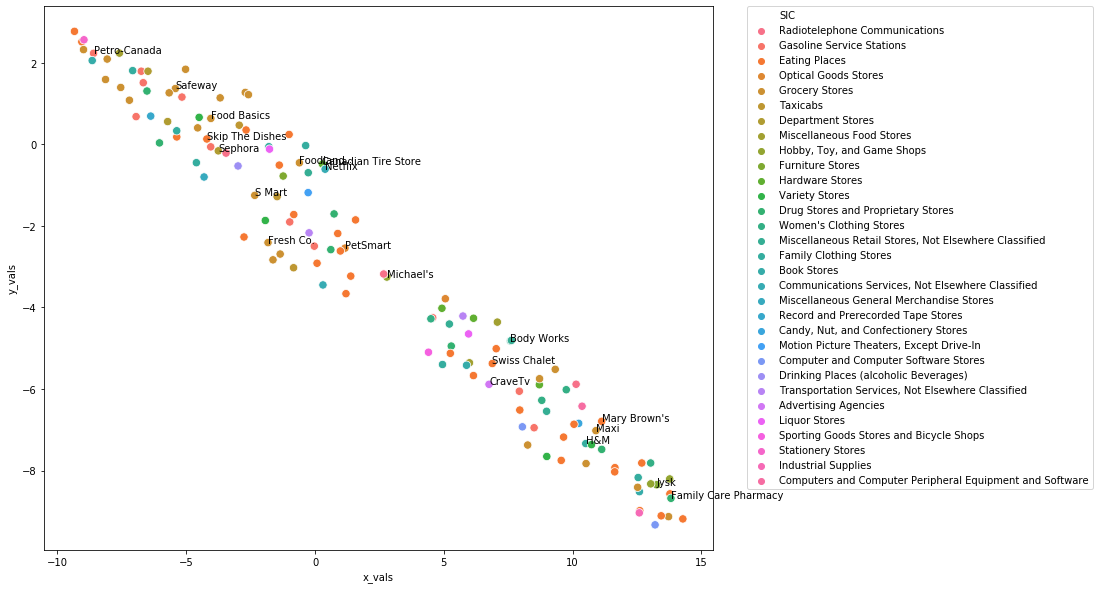

In [37]:
plt.figure(figsize=(12, 10))
sns.scatterplot(data = df2plot, x="x_vals", y="y_vals", hue="SIC", s=70, legend = 'brief');

# put legend outside the box
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# randomly label the retailers
indices = list(range(len(labels)))
selected_indices = random.sample(indices, 20)
for i in selected_indices:
    plt.annotate(labels[i], (x_vals[i], y_vals[i]))

In [21]:
#plot_with_matplotlib(x_vals, y_vals, labels)